In [ ]:
import os
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

import os
import zipfile
import requests

In [ ]:
zip_url='https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip'
zip_path='/content/jena_climate_2009_2016.csv.zip'
csv_path='/content/jena_climate_2009_2016.csv'

# downaload zip file
response = requests.get(zip_url)
with open(zip_path, "wb") as file:
    file.write(response.content)

# extract zip file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("/content")

# load data
with open(csv_path, "r") as file:
    data = file.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
print(float_data.shape)

(420451, 14)


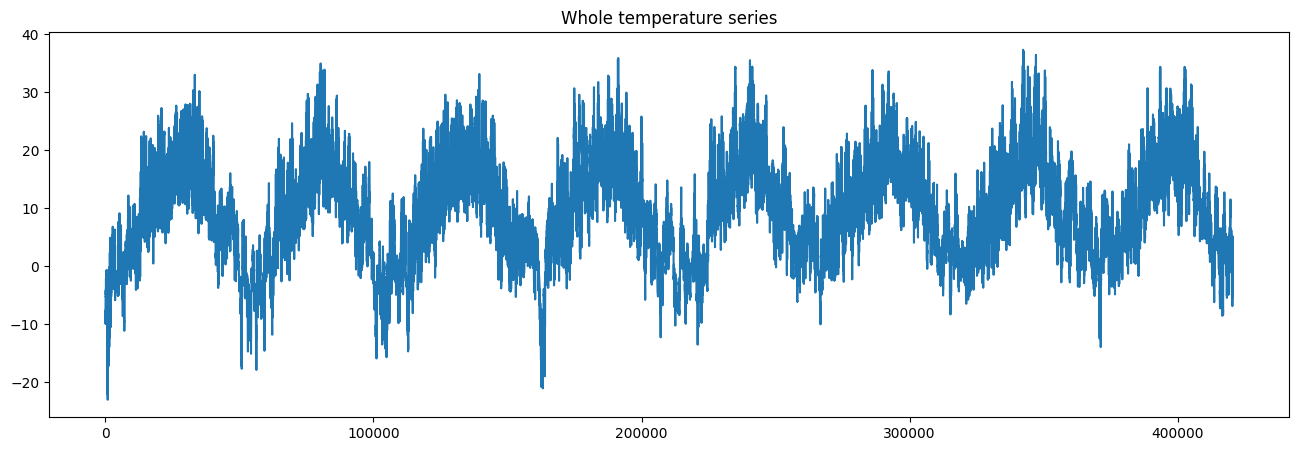

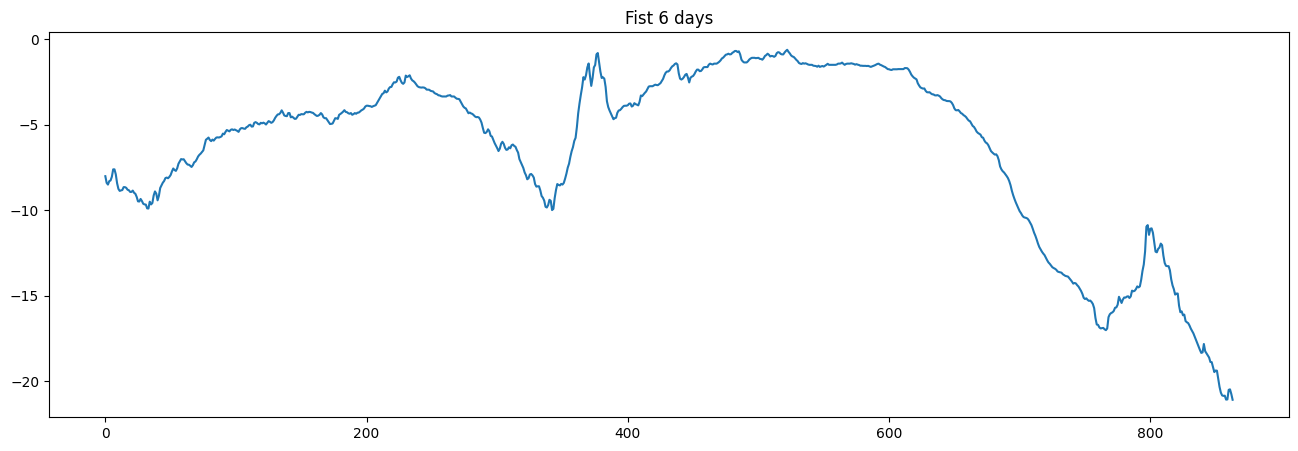

In [ ]:
temp = float_data[:, 1]

#TODO: Plot whole temperature series, notice yearly trends
plt.figure(figsize=(16,5))
plt.plot(temp)
plt.title("Whole temperature series")
plt.show()

#TODO: Plot the first 6 days (timestep=10min)
plt.figure(figsize=(16,5))
plt.plot(range(6*24*6), temp[:6*24*6])
plt.title("Fist 6 days")
plt.show()

In [ ]:
float_data = (float_data - np.mean(float_data, axis=0)) / np.std(float_data[:200000, :], axis=0)

In [ ]:
# generator function used to feed the training, validation and test data

def generator(data, lookback, delay, min_index, max_index,
                shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [ ]:
#TODO Define lookback, step, delay and batch size variable
lookback=720
delay=144
step=6
batch_size=128

train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=200000,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)

#TODO: Set a validation generator similar to train generator. Use next 100000 samples (max index from 200,000 to 300,000). Do not shuftle the data:

val_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=200000,
                        max_index=300000,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

#TODO: Set a validation generator similar to a train generator. Use further next 100000 samples (max index from 300,000 onwards). Do not shuffle the data:

test_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=300000,
                        max_index=400000,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
# Number of steps to draw from val_gen to see the entire validation set
val_steps = (300000 - 200001 - lookback)//batch_size

#Train the network for about 20 epochs
history = model.fit(train_gen, epochs=20, steps_per_epoch=500, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1897 - val_loss: 0.3385
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1884 - val_loss: 0.3188
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1884 - val_loss: 0.3238
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1892 - val_loss: 0.3280
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.1879 - val_loss: 0.3244
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1889 - val_loss: 0.3261
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.1863 - val_loss: 0.3165
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.1865 - val_loss: 0.3218
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.1881 - val_loss: 0.3219
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.1871 - val_loss: 0.3235
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.1868 - val_loss: 0.3227
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 

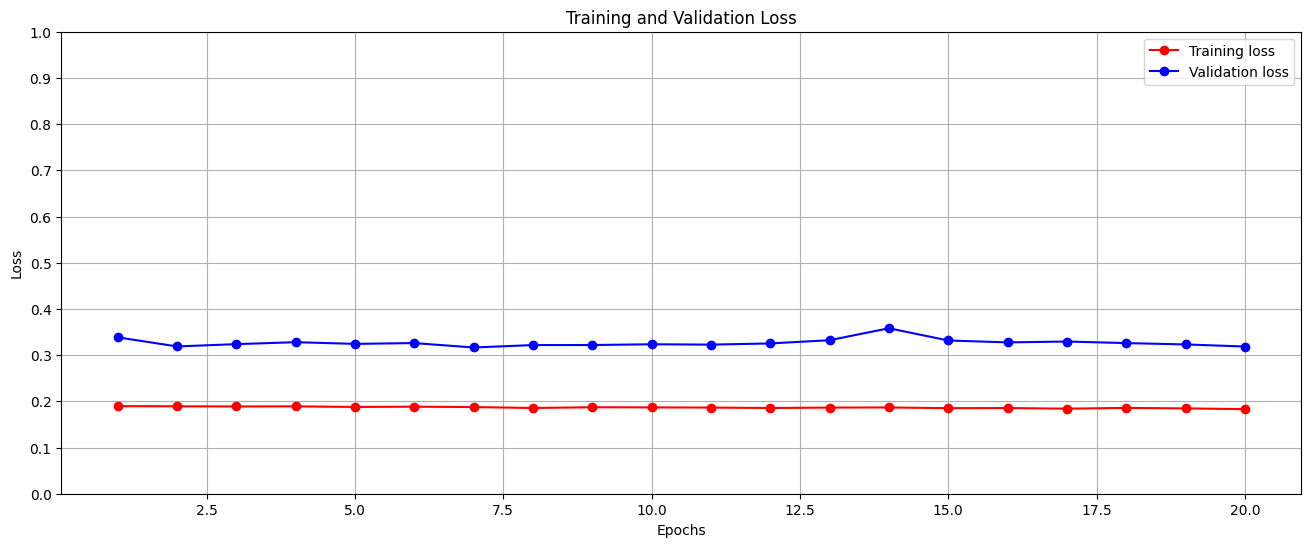

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
plt.figure(figsize=(16, 6))

plt.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

loss_ticks = np.arange(0, 1.1, 0.1)
plt.yticks(loss_ticks)

plt.show()


In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
#Train the network for about 20 epochs
history = model.fit(train_gen, epochs=20, steps_per_epoch=500, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.3280 - val_loss: 0.2719
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.2884 - val_loss: 0.2666
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.2794 - val_loss: 0.2634
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2762 - val_loss: 0.2656
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.2686 - val_loss: 0.2677
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.2656 - val_loss: 0.2674
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.2599 - val_loss: 0.2697
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.2565 - val_loss: 0.2694
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.2514 - val_loss: 0.2819
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.2488 - val_loss: 0.2761
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.2421 - val_loss: 0.2770
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━━━━

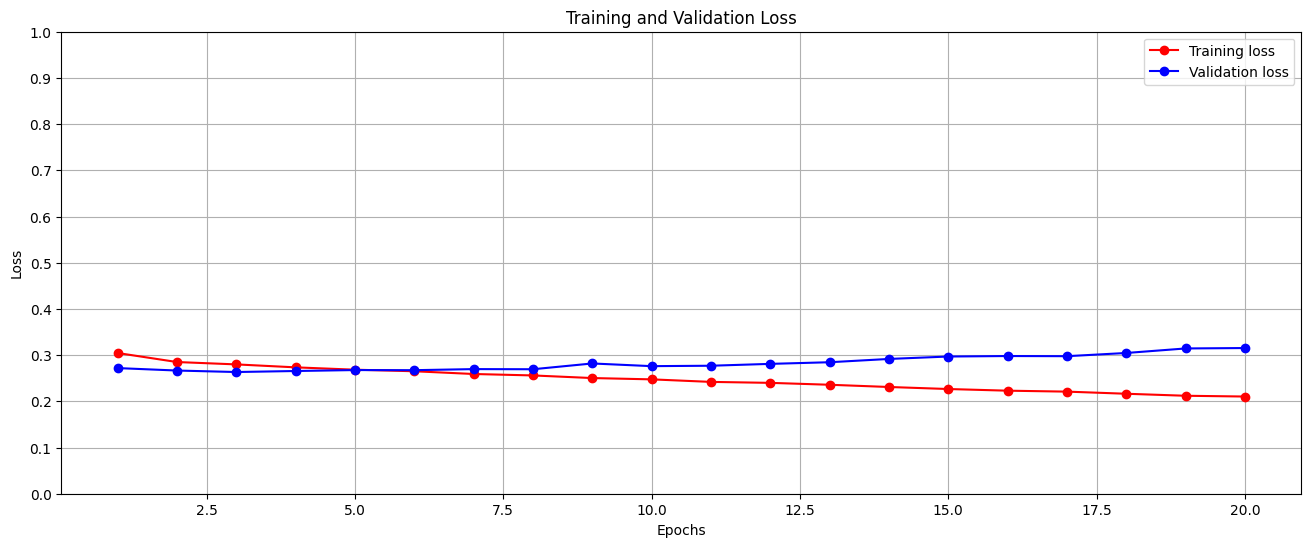

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
plt.figure(figsize=(16, 6))

plt.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

loss_ticks = np.arange(0, 1.1, 0.1)
plt.yticks(loss_ticks)

plt.show()


In [ ]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
#Train the network for about 20 epochs
history = model.fit(train_gen, epochs=40, steps_per_epoch=500, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.3360 - val_loss: 0.2772
Epoch 2/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.2789 - val_loss: 0.2663
Epoch 3/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2720 - val_loss: 0.2671
Epoch 4/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.2645 - val_loss: 0.2778
Epoch 5/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.2607 - val_loss: 0.2660
Epoch 6/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2564 - val_loss: 0.2707
Epoch 7/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2504 - val_loss: 0.2807
Epoch 8/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2481 - val_loss: 0.2684
Epoch 9/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2421 - val_loss: 0.2677
Epoch 10/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.2380 - val_loss: 0.2734
Epoch 11/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2348 - val_loss: 0.2758
Epoch 12/40
500/500 ━━━━━━━━━━

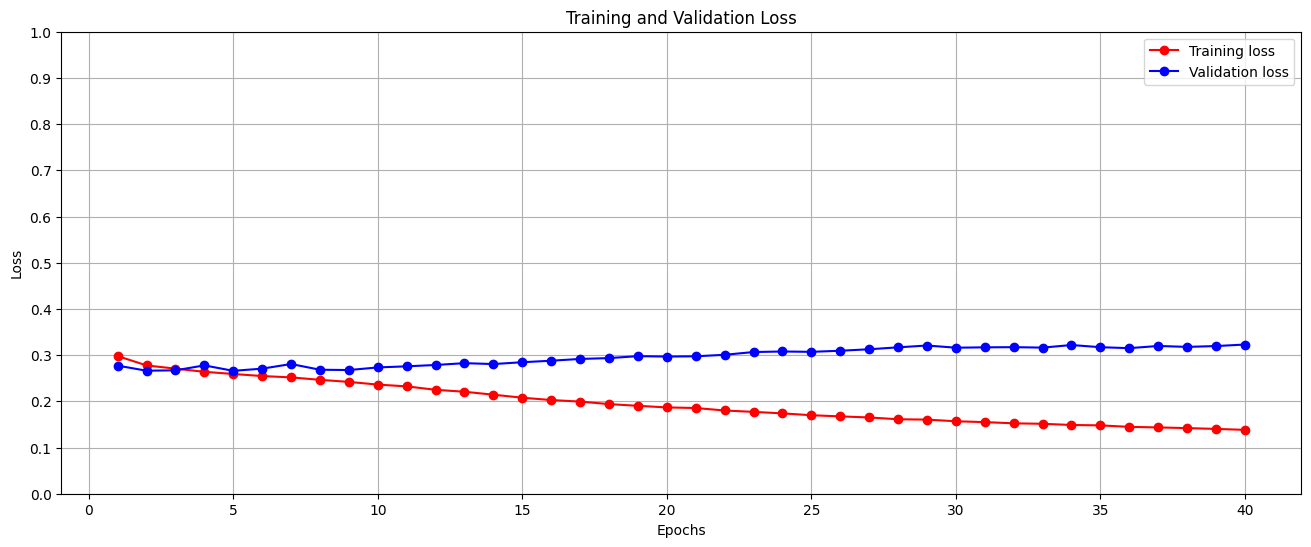

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
plt.figure(figsize=(16, 6))

plt.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

loss_ticks = np.arange(0, 1.1, 0.1)
plt.yticks(loss_ticks)

plt.show()


In [ ]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32))
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
#Train the network for about 20 epochs
history = model.fit(train_gen, epochs=20, steps_per_epoch=500, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 123ms/step - loss: 0.3629 - val_loss: 0.2957
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.2954 - val_loss: 0.2912
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.2804 - val_loss: 0.3072
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.2659 - val_loss: 0.3017
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.2529 - val_loss: 0.3054
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.2388 - val_loss: 0.3168
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.2249 - val_loss: 0.3209
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.2128 - val_loss: 0.3237
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.2057 - val_loss: 0.3269
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.1957 - val_loss: 0.3318
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.1885 - val_loss: 0.3366
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━━

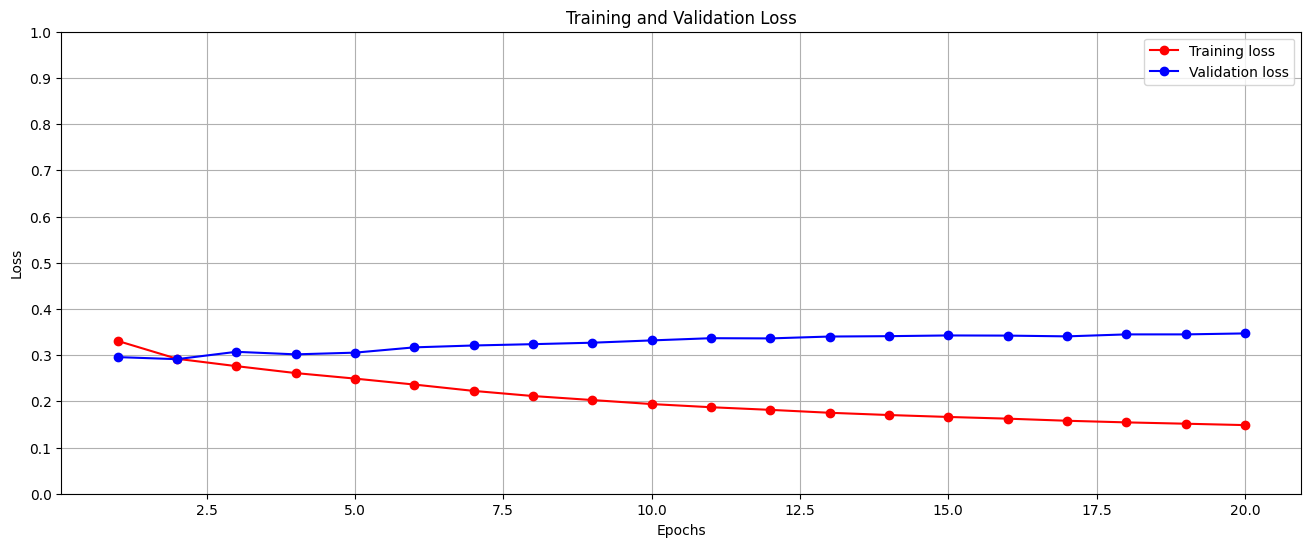

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
plt.figure(figsize=(16, 6))

plt.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

loss_ticks = np.arange(0, 1.1, 0.1)
plt.yticks(loss_ticks)

plt.show()
